In [1]:
"""
The project leverages word vector representations to create an Emojifier. It takes as input a sentence and
identifies the most suitable emoji for it. Examples include:
    Job well done! 👍
    Let's get coffee and talk. ☕️
    I love you! ❤️
    Let's watch the baseball game tomorrow! ⚾️
"""

import os
import numpy as np
from matplotlib import pyplot as plt
from utils_emojify import *
np.random.seed(1)

In [2]:
# IMPORT THE DATASET
train_data_path = os.path.join(os.getcwd(), 'data', 'train_emoji.csv')
test_data_path = os.path.join(os.getcwd(), 'data', 'test_emoji.csv')

X_train, Y_train = read_csv_reader(train_data_path)
X_test, Y_test = read_csv_reader(test_data_path)

# Find the length of the longest sentence in the training dataset.
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())

In [3]:
print(f"The length of the longest sentence in the training set: {maxLen}") 

The length of the longest sentence in the training set: 10


In [4]:
# Looking at some of the examples in the dataset
for idx in range(10):
    print(X_train[idx], convert_label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


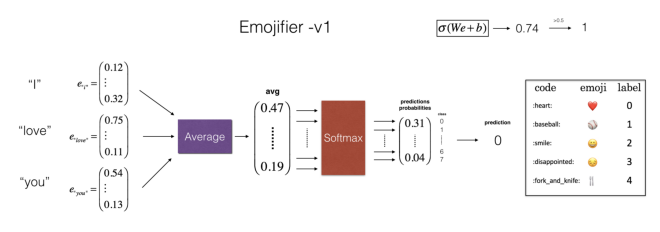

In [5]:
# BUILDING THE EMOJIFIER
# Here is the model to build
model_img = plt.imread(os.path.join(os.getcwd(), 'images', 'emojifier_v1.png'))
plt.imshow(model_img)
plt.axis("off")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.show()

In [6]:
# One-hot encoding the targets
C = len(label_to_emoji_dict.keys())  # Number of classes
Y_oh_train = convert_to_one_hot(Y_train, num_classes=C)
Y_oh_test = convert_to_one_hot(Y_test, num_classes=C)

In [7]:
# Implementation verification
idx = 10
print(f"The sentence '{X_train[idx]}' has label index '{Y_train[idx]}',"
      f" which is emoji {convert_label_to_emoji(Y_train[idx])}", )
print(f"Label index '{Y_train[idx]}' in one-hot encoding format is {Y_oh_train[idx]}")

The sentence 'she did not answer my text ' has label index '3', which is emoji 😞
Label index '3' in one-hot encoding format is [0. 0. 0. 1. 0. 0.]


In [8]:
# Convert each word in the input sentence into their word vector representations
glove_file = os.path.join(os.getcwd(), 'data', 'glove.6B.100d.txt')  # 'glove.42B.300d.txt'
word_to_index, index_to_word, word_to_vec_map = read_glove_vectors(glove_file)

In [9]:
# Implementation verification
word = "potatos"
idx = 113317
print(f"The index of {word}, in the vocabulary is, {word_to_index[word]}")
print(f"The {idx}th word in the vocabulary is {index_to_word[idx]}")

The index of potatos, in the vocabulary is, 289846
The 113317th word in the vocabulary is cucumber


In [11]:
# Step 1: Averaging all the embeddings in a sentence
def sentence_to_avg(sentence, word_to_vector_map):
    """
    Converts a sentence into a single vector by averaging the GloVe representations of its words.

    Arguments:
        sentence (str): The input sentence.
        word_to_vector_map (dict): Python dictionary mapping words to their GloVe vectors.

    Returns:
        avg (np.ndarray): The average vector encoding the sentence, shape (J,).
    """

    # Get a valid word contained in the word_to_vec_map.
    any_word = next(iter(word_to_vector_map.keys()))

    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector and count
    avg = np.zeros_like(word_to_vector_map[any_word])
    count = 0

    # Average the word vectors.
    for w in words:
        if w in word_to_vector_map.keys():
            avg += np.array(word_to_vector_map[w])
            count += 1

    if count > 0:
        avg = avg / count

    return avg

In [12]:
# Verification
my_sentence = "potatos and cucumber"
avg_glove = sentence_to_avg(my_sentence, word_to_vec_map)

assert np.all(avg_glove != 0), "The GloVe vector contains zero values."

In [15]:
# Step 2: Implementing and training the model
def model(X, Y, word_to_vector_map, learning_rate=0.001, num_iterations=400):
    """
    Trains a softmax-based model to predict labels for input sentences using pre-trained word vectors.

    Arguments:
        X (numpy.ndarray): Input data, a numpy array of sentences as strings, of shape (m,).
        Y (numpy.ndarray): Labels, a numpy array of integers between 0 and n_y-1, of shape (m, 1).
        word_to_vector_map (dict): A dictionary mapping words to their  GloVe vector representations.
        learning_rate (float): Learning rate for the Stochastic Gradient Descent (SGD) algorithm. Default is 0.001.
        num_iterations (int): Number of training iterations. Default value is 400.

    Returns:
        preds (numpy.ndarray): Vector of predictions, of shape (m, 1).
        W (numpy.ndarray): Weight matrix for the softmax layer, of shape (n_y, n_h).
        b (numpy.ndarray): Bias vector for the softmax layer, of shape (n_y,).
    """

    # Get a valid word contained in the word_to_vec_map
    any_word = next(iter(word_to_vector_map.keys()))

    # Define number of training examples
    m = Y.shape[0]  # number of training examples
    n_y = len(np.unique(Y))  # number of classes
    n_h = word_to_vector_map[any_word].shape[0]  # dimensions of the GloVe vectors

    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, num_classes=n_y)

    # Optimization loop
    for t in range(num_iterations):  # Loop over the number of iterations

        cost = 0
        dW = 0
        db = 0

        for i in range(m):
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer.
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Add the cost
            cost += -np.sum(Y_oh[i, :] * np.log(a))

            # Compute gradients
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y, 1), avg.reshape(1, n_h))
            db += dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 50 == 0 or t == num_iterations - 1:
            preds, accuracy = predict(X, Y, W, b, word_to_vec_map)  # predict() is defined in utils_emojify.py
            print(f"Epoch: {t} ---> Cost = {cost:.6f}, Accuracy = {accuracy:.6f}")

    return preds, W, b

In [16]:
prediction, W, b = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 ---> Cost = 215.653269, Accuracy = 0.643939
Epoch: 50 ---> Cost = 21.861966, Accuracy = 0.946970
Epoch: 100 ---> Cost = 13.889151, Accuracy = 0.984848
Epoch: 150 ---> Cost = 10.266168, Accuracy = 0.984848
Epoch: 200 ---> Cost = 8.117823, Accuracy = 0.992424
Epoch: 250 ---> Cost = 6.688410, Accuracy = 0.992424
Epoch: 300 ---> Cost = 5.669879, Accuracy = 0.992424
Epoch: 350 ---> Cost = 4.910899, Accuracy = 0.992424
Epoch: 399 ---> Cost = 4.337095, Accuracy = 1.000000


In [17]:
# PERFORMANCE EVALUATION
pred_train, acc_train = predict(X_train, Y_train, W, b, word_to_vec_map)
pred_test, acc_test = predict(X_test, Y_test, W, b, word_to_vec_map)
print(f"Training set accuracy: {acc_train:.6f}")
print(f"Test set accuracy: {acc_test:.6f}")

Training set accuracy: 1.000000
Test set accuracy: 0.929825


In [18]:
# Try with some sentences
my_sentences = np.array(["I treasure you", "I love you", "You are too funny lol", "Time to eat some food",
                         "A little sick", "He is not in good health"])

my_labels = np.array([[0], [0], [2], [4], [3], [3]])

pred, acc = predict(my_sentences, my_labels, W, b, word_to_vec_map)
print_predictions(my_sentences, pred)


I treasure you ❤️
I love you ❤️
You are too funny lol 😄
Time to eat some food 🍴
A little sick ❤️
He is not in good health 😄


In [19]:
# Notes:
# - The algorithm generalizes well to similar words (e.g., "treasure" and "love"), even if they're not seen in training.
# - This is because words like "heart," "dear," "beloved," or "adore" have embeddings similar to "love."
# - It fails to identify "a little sick" and "He is not in good health"
# - This is because the model does not consider word ordering, but instead averages all the words' embeddings.
# - See Sentiment_Analysis_v2 (a better algorithm that uses LSTM)


------------Confusion Matrix------------
           ❤️   ⚾   😄   😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            9    0    1    1    0   11
1            0    8    0    0    0    8
2            1    0   13    0    0   14
3            1    0    0   16    0   17
4            0    0    0    0    7    7
All         11    8   14   17    7   57


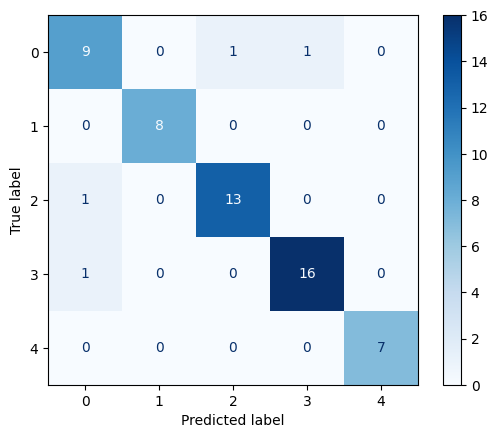

In [20]:
# CONFUSION MATRIX
print("\n------------Confusion Matrix------------")
emoji_labels = list(np.unique(Y_train))
# Generate the string with emojis
emoji_str = '           ' + '   '.join(convert_label_to_emoji(label) for label in emoji_labels)
print(emoji_str)
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test, c_map=plt.cm.Blues)